In [1]:

%pprint

Pretty printing has been turned OFF



## Let's use our labeled data to train a Latent Dirichlet Allocation model

In [2]:

%%time
%run ../py/html_analysis.py

lda = LdaUtilities(verbose=True)

Wall time: 24.8 s


In [3]:

sent_str = '<b>SQL experience</b>'
lda.lda_predict_single(sent_str)

'O'

In [4]:

sent_str = 'You work here.'
lda.lda_predict_single(sent_str)

'O'

In [5]:

[f'lda.{fn}' for fn in dir(lda) if not fn.startswith('_')]

['lda.LDA_CORPUS', 'lda.LDA_DICTIONARY', 'lda.NAVIGABLE_PARENT_IS_HEADER_DICT', 'lda.TOPIC_MODEL', 'lda.build_corpus', 'lda.build_dictionary', 'lda.build_lda_predict_single', 'lda.build_topic_model', 'lda.conn', 'lda.cursor', 'lda.get_pos_count', 'lda.get_tokenized_sents_list', 'lda.ha', 'lda.hc', 'lda.lda_predict_single', 'lda.stopwords_list', 'lda.su', 'lda.tokenized_sents_list', 'lda.topic_dict']

In [6]:

d = lda.LDA_DICTIONARY
[f'd.{fn}' for fn in dir(d) if not fn.startswith('_')]

['d.add_documents', 'd.cfs', 'd.compactify', 'd.dfs', 'd.doc2bow', 'd.doc2idx', 'd.filter_extremes', 'd.filter_n_most_frequent', 'd.filter_tokens', 'd.from_corpus', 'd.from_documents', 'd.get', 'd.id2token', 'd.items', 'd.iteritems', 'd.iterkeys', 'd.itervalues', 'd.keys', 'd.load', 'd.load_from_text', 'd.merge_with', 'd.num_docs', 'd.num_nnz', 'd.num_pos', 'd.patch_with_special_tokens', 'd.save', 'd.save_as_text', 'd.token2id', 'd.values']

In [7]:

import random

for k, v in random.sample(d.items(), 10):
    print(k, v)

259 Preferred
15 clinical
103 which
249 communicate
268 employer
25 etc
201 teams
244 create
209 value
160 Ability


In [8]:

c = lda.LDA_CORPUS
[f'c.{fn}' for fn in dir(c) if not fn.startswith('_')]

['c.append', 'c.clear', 'c.copy', 'c.count', 'c.extend', 'c.index', 'c.insert', 'c.pop', 'c.remove', 'c.reverse', 'c.sort']

In [9]:

random.sample(c, 2)

[[(25, 1), (165, 1), (227, 1), (245, 1), (304, 1), (305, 1)], [(114, 1), (285, 1)]]

In [10]:

tm = lda.TOPIC_MODEL
[f'tm.{fn}' for fn in dir(tm) if not fn.startswith('_')]

['tm.alpha', 'tm.bound', 'tm.callbacks', 'tm.chunksize', 'tm.clear', 'tm.decay', 'tm.diff', 'tm.dispatcher', 'tm.distributed', 'tm.do_estep', 'tm.do_mstep', 'tm.dtype', 'tm.eta', 'tm.eval_every', 'tm.expElogbeta', 'tm.gamma_threshold', 'tm.get_document_topics', 'tm.get_term_topics', 'tm.get_topic_terms', 'tm.get_topics', 'tm.id2word', 'tm.inference', 'tm.init_dir_prior', 'tm.iterations', 'tm.load', 'tm.log_perplexity', 'tm.minimum_phi_value', 'tm.minimum_probability', 'tm.num_terms', 'tm.num_topics', 'tm.num_updates', 'tm.numworkers', 'tm.offset', 'tm.optimize_alpha', 'tm.optimize_eta', 'tm.passes', 'tm.per_word_topics', 'tm.print_topic', 'tm.print_topics', 'tm.random_state', 'tm.save', 'tm.show_topic', 'tm.show_topics', 'tm.state', 'tm.sync_state', 'tm.top_topics', 'tm.update', 'tm.update_alpha', 'tm.update_eta', 'tm.update_every']

In [11]:

# Was (26, 6020)
tm.get_topics().shape

(2, 306)


## Test its accuracy

In [12]:

true_positive_count = false_negative_count = true_negative_count = false_positive_count = 0
y_true = []
y_pred = []
for sent_str, is_header in lda.NAVIGABLE_PARENT_IS_HEADER_DICT.items():
    y_true.append(['O', 'H'][is_header])
    prediction = lda.lda_predict_single(sent_str)
    y_pred.append(prediction)
    
    # True positives and false negatives
    if is_header:
        if prediction == 'H':
            true_positive_count += 1
        else:
            false_negative_count += 1
    
    # True negatives and false positives
    else:
        if prediction == 'O':
            true_negative_count += 1
        else:
            false_positive_count += 1

In [13]:

# (1164, 104, 5341, 3967)
true_positive_count, false_negative_count, false_positive_count, true_negative_count

(56, 1212, 6679, 2629)

In [14]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[  56, 1212],
       [6679, 2629]], dtype=int64)

In [15]:

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           H       0.01      0.04      0.01      1268
           O       0.68      0.28      0.40      9308

    accuracy                           0.25     10576
   macro avg       0.35      0.16      0.21     10576
weighted avg       0.60      0.25      0.35     10576



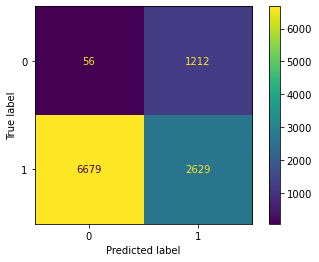

In [16]:

from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [18]:

# Compute Perplexity: a measure of how good the model is – the lower the better
# Was -7.something
tm = lda.TOPIC_MODEL
c = lda.LDA_CORPUS
tm.log_perplexity(c)

-5.31989505604152

In [19]:

from gensim.models import CoherenceModel

# Compute Coherence Score
d = lda.LDA_DICTIONARY
cm = CoherenceModel(model=tm, texts=lda.tokenized_sents_list, corpus=c, dictionary=d)

# Was 0.6278934608305464
cm.get_coherence()

0.6278934608305464

In [22]:

coherence_measures_list = ['u_mass', 'c_v', 'c_uci', 'c_npmi']
for coherence in coherence_measures_list:
    cm = CoherenceModel(model=tm, texts=lda.tokenized_sents_list, corpus=c, dictionary=d, coherence=coherence)
    print(f'{coherence}: {cm.get_coherence()}')

u_mass: -2.4250956933076147
c_v: 0.6278934608305464
c_uci: -0.20255193393959373
c_npmi: -0.0038320213839276324


In [23]:

state = tm.state
[f'state.{fn}' for fn in dir(state) if not fn.startswith('_')]

['state.blend', 'state.blend2', 'state.dtype', 'state.eta', 'state.get_Elogbeta', 'state.get_lambda', 'state.load', 'state.merge', 'state.numdocs', 'state.reset', 'state.save', 'state.sstats']

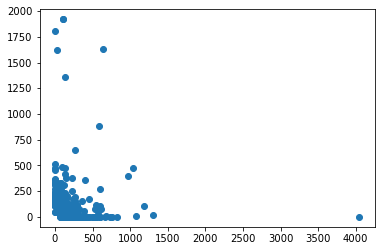

In [24]:

import matplotlib.pyplot as plt
import numpy as np

# (2, 6019)
plt.scatter(state.sstats[0], state.sstats[1])
plt.show()